# **Step1: Design PBCN system for learning**

First we design the environment variables using the knowledge of PBCN parameters, dynamics and rewarding scheme. For other Markovian process that can be extracted from standard libraries like "gym" this step can be omitted.

Once the system is designed and the dynamics computed, we visualize attractors using "networkx" package, which also helps finding attractors in turn seggregating desired and undesired attractors.

Graph with combination U=00


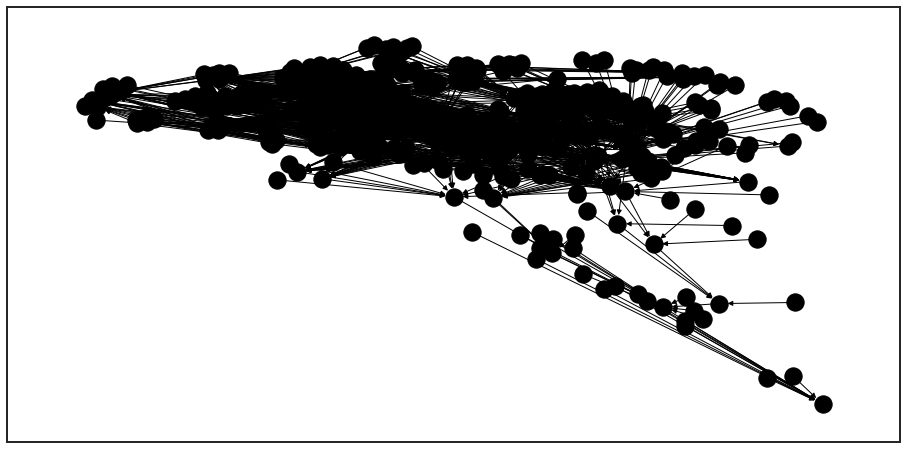

Graph with combination U=01


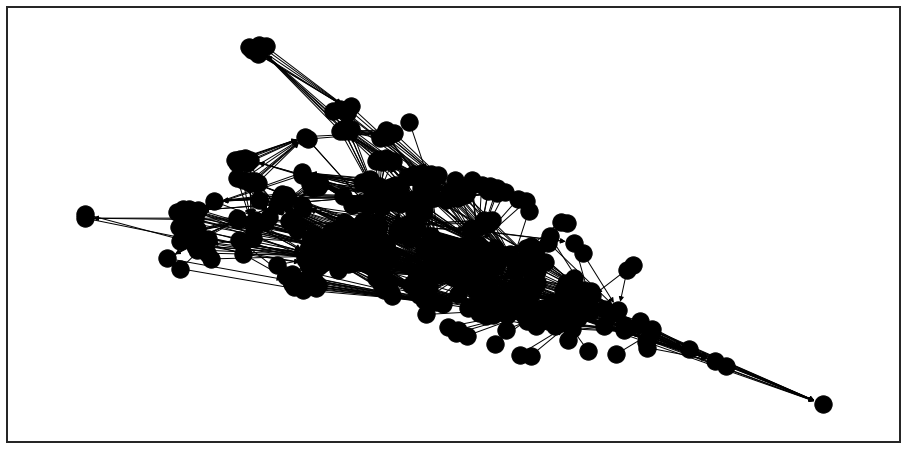

Graph with combination U=10


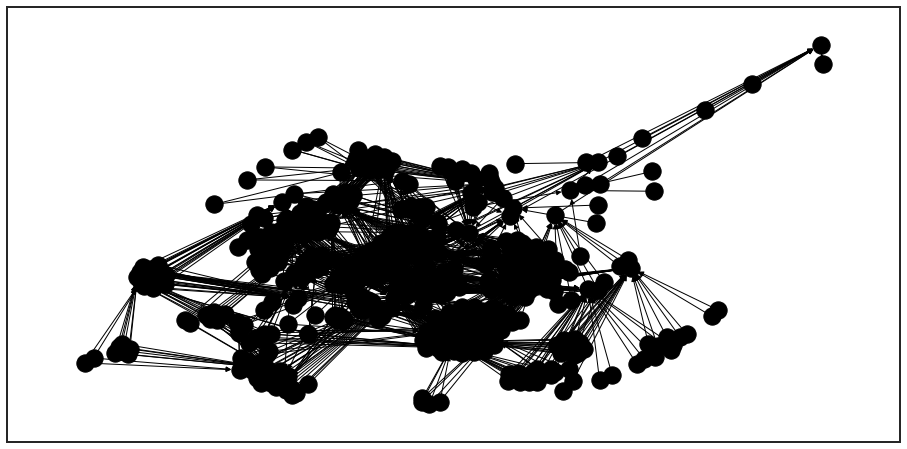

Graph with combination U=11


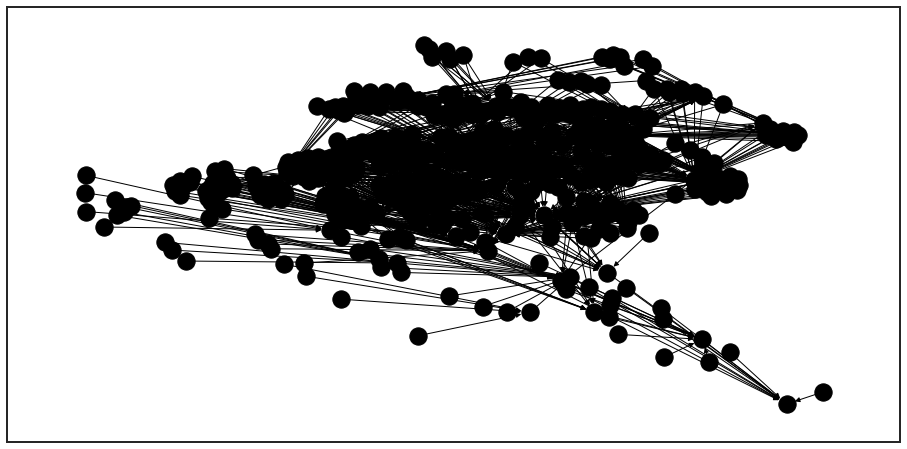

In [8]:
# Import libraries required for PBCN problem
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
# from keras.models import Sequential
# from keras.layers import Dense
# from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
# from keras.wrappers.scikit_learn import KerasClassifier
# from sklearn.model_selection import KFold
# from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
# from sklearn.pipeline import Pipeline
# from sklearn.model_selection import train_test_split
import multiprocessing as mp
import numpy as np
import pandas as pd
import random as rd
import matplotlib.pyplot as plt
import itertools
import pandas as pd
import pylab as plt
import networkx as nx
import numpy as np
import time
import sys

# ---------------------->>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> Creating PBCN Parameters <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<----------------------------

ns = 9 # Number of State variables
nc = 2 # Number of Control variables
n = ns + nc # Total variables

# Generate table of all possible binary combinations between states-action pairs
table = list(itertools.product([0, 1], repeat=n))

# function to convert boolean to decimal values
def bool2dec(table_name,n_val,table_len,flag):
  dec_value=np.zeros(table_len)
  for i in range(0,table_len):
    for j in range(0,n_val):
      if flag==0:                           # flag defines if control u is taken into consideration or not
        dec_value[i]=(np.power(2,(n_val-j-1)))*table_name[i][j+nc]+dec_value[i] # for u at the beginning
      else:
        dec_value[i]=(np.power(2,(n_val-j-1)))*table_name[i][j]+dec_value[i] # for u at the beginning
  return dec_value

value=bool2dec(table,ns,len(table),0)
df=pd.DataFrame([table[0:len(table)],value])  # Dataframe comprising of state-action pairs and corresponding decimal values

no_of_perm = 4                              # no of possible permutations in reference to states possessing sub network structure
no_of_vars_with_diff_paths = 2              # no of variables possesing sub networks
if no_of_vars_with_diff_paths==1:
  f = np.zeros([ns+int(no_of_vars_with_diff_paths),df.shape[1]])    # f=[[f11f21f31],[f11f22f31],[f12f21f31]...] all possible dynamical functions
else:
  f = np.zeros([ns+int(no_of_perm/no_of_vars_with_diff_paths),df.shape[1]])     # f=[[f11f21f31],[f11f22f31],[f12f21f31]...] all possible dynamical functions

# Boolean dynamics of the system given by x_{k+1} = f_{x_{k},u_{k}}
for i in range(0,df.shape[1]):
  f[0,i]=(1-df[i][0][8]) and df[i][0][4]
  f[1,i]=df[i][0][2]
  f[2,i]=(1-df[i][0][0])
  f[3,i]=df[i][0][6] and df[i][0][7]
  f[4,i]=(1-df[i][0][0]) and df[i][0][3] and df[i][0][1]
  f[5,i]=df[i][0][6]
  f[6,i]=df[i][0][2]
  f[7,i]=(1-df[i][0][5]) and (1-df[i][0][9])
  f[8,i]=df[i][0][5] or df[i][0][6] or df[i][0][10]
  f[9,i]=(1-df[i][0][0]) and (df[i][0][6] or df[i][0][1])
  f[10,i]=df[i][0][10]

# creating and storing dataframes for individual sub networks
dummy_df=pd.DataFrame([f[0,:],f[1,:],f[2,:],f[3,:],f[4,:],f[6,:],f[7,:],f[8,:],f[9,:]])
df2=pd.DataFrame([f[0,:],f[1,:],f[2,:],f[3,:],f[4,:],f[6,:],f[7,:],f[8,:],f[9,:],bool2dec(dummy_df,ns,df.shape[1],1)])    # subnetwork with combination: sc1 = f11,f21,f31...f51...f91
dummy_df=pd.DataFrame([f[0,:],f[1,:],f[2,:],f[3,:],f[5,:],f[6,:],f[7,:],f[8,:],f[9,:]])
df3=pd.DataFrame([f[0,:],f[1,:],f[2,:],f[3,:],f[5,:],f[6,:],f[7,:],f[8,:],f[9,:],bool2dec(dummy_df,ns,df.shape[1],1)])    # subnetwork with combination: sc1 = f11,f21,f31...f52...f91
dummy_df=pd.DataFrame([f[0,:],f[1,:],f[2,:],f[3,:],f[4,:],f[6,:],f[7,:],f[8,:],f[10,:]])
df4=pd.DataFrame([f[0,:],f[1,:],f[2,:],f[3,:],f[4,:],f[6,:],f[7,:],f[8,:],f[10,:],bool2dec(dummy_df,ns,df.shape[1],1)])   # subnetwork with combination: sc1 = f11,f21,f31...f51...f92
dummy_df=pd.DataFrame([f[0,:],f[1,:],f[2,:],f[3,:],f[5,:],f[6,:],f[7,:],f[8,:],f[10,:]])
df5=pd.DataFrame([f[0,:],f[1,:],f[2,:],f[3,:],f[5,:],f[6,:],f[7,:],f[8,:],f[10,:],bool2dec(dummy_df,ns,df.shape[1],1)])   # subnetwork with combination: sc1 = f11,f21,f31...f52...f92

# probability associated with fij
pc = np.ones(f.shape[0])
pc[0]=1.0
pc[1]=1.0
pc[2]=1.0
pc[3]=1.0
pc[4]=0.7
pc[5]=0.3
pc[6]=1.0
pc[7]=1.0
pc[8]=1.0
pc[9]=0.6
pc[10]=0.4


points_list_U1=list()     # transitions in decimal form with control u = 00
points_list_U2=list()     # transitions in decimal form with control u = 01
points_list_U3=list()     # transitions in decimal form with control u = 10
points_list_U4=list()     # transitions in decimal form with control u = 11
edge_weights_U1={}        # probabilities of transitions with control u = 00
edge_weights_U2={}        # probabilities of transitions with control u = 01
edge_weights_U3={}        # probabilities of transitions with control u = 10
edge_weights_U4={}        # probabilities of transitions with control u = 11

# notations indicating control chosen
control_dict={0:"u1=0,u2=0",
             1:"u1=0,u2=1",
             2:"u1=1,u2=0",
             3:"u1=1,u2=1",
            -1:"No Control"}

c = np.power(2,ns)
for i in range(np.power(2,ns)):                             # transitions are calculated in reference to the underlying dynamical equations and corresponding probabilities are stored
  points_list_U1.append((df[i].iloc[-1],df2[i].iloc[-1]))
  edge_weights_U1[points_list_U1[-1]]=str(np.round(pc[0]*pc[1]*pc[2]*pc[3]*pc[4]*pc[6]*pc[7]*pc[8]*pc[9],2))
  points_list_U1.append((df[i].iloc[-1],df3[i].iloc[-1]))
  if points_list_U1[-1] in points_list_U1[0:len(points_list_U1)-1]:
    edge_weights_U1[points_list_U1[-1]]=str(float(edge_weights_U1[points_list_U1[-1]])+np.round(pc[0]*pc[1]*pc[2]*pc[3]*pc[5]*pc[6]*pc[7]*pc[8]*pc[9],2))
  else:
    edge_weights_U1[points_list_U1[-1]]=str(np.round(pc[0]*pc[1]*pc[2]*pc[3]*pc[5]*pc[6]*pc[7]*pc[8]*pc[9],2))
  points_list_U1.append((df[i].iloc[-1],df4[i].iloc[-1]))
  if points_list_U1[-1] in points_list_U1[0:len(points_list_U1)-1]:
    edge_weights_U1[points_list_U1[-1]]=str(float(edge_weights_U1[points_list_U1[-1]])+np.round(pc[0]*pc[1]*pc[2]*pc[3]*pc[4]*pc[6]*pc[7]*pc[8]*pc[10],2))
  else:
    edge_weights_U1[points_list_U1[-1]]=str(np.round(pc[0]*pc[1]*pc[2]*pc[3]*pc[4]*pc[6]*pc[7]*pc[8]*pc[10],2))
  points_list_U1.append((df[i].iloc[-1],df5[i].iloc[-1]))
  if points_list_U1[-1] in points_list_U1[0:len(points_list_U1)-1]:
    edge_weights_U1[points_list_U1[-1]]=str(float(edge_weights_U1[points_list_U1[-1]])+np.round(pc[0]*pc[1]*pc[2]*pc[3]*pc[5]*pc[6]*pc[7]*pc[8]*pc[10],2))
  else:
    edge_weights_U1[points_list_U1[-1]]=str(np.round(pc[0]*pc[1]*pc[2]*pc[3]*pc[5]*pc[6]*pc[7]*pc[8]*pc[10],2))

  points_list_U2.append((df[i+c].iloc[-1],df2[i+c].iloc[-1]))
  edge_weights_U2[points_list_U2[-1]]=str(np.round(pc[0]*pc[1]*pc[2]*pc[3]*pc[4]*pc[6]*pc[7]*pc[8]*pc[9],2))
  points_list_U2.append((df[i+c].iloc[-1],df3[i+c].iloc[-1]))
  if points_list_U2[-1] in points_list_U2[0:len(points_list_U2)-1]:
    edge_weights_U2[points_list_U2[-1]]=str(float(edge_weights_U2[points_list_U2[-1]])+np.round(pc[0]*pc[1]*pc[2]*pc[3]*pc[5]*pc[6]*pc[7]*pc[8]*pc[9],2))
  else:
    edge_weights_U2[points_list_U2[-1]]=str(np.round(pc[0]*pc[1]*pc[2]*pc[3]*pc[5]*pc[6]*pc[7]*pc[8]*pc[9],2))
  points_list_U2.append((df[i+c].iloc[-1],df4[i+c].iloc[-1]))
  if points_list_U2[-1] in points_list_U2[0:len(points_list_U2)-1]:
    edge_weights_U2[points_list_U2[-1]]=str(float(edge_weights_U2[points_list_U2[-1]])+np.round(pc[0]*pc[1]*pc[2]*pc[3]*pc[4]*pc[6]*pc[7]*pc[8]*pc[10],2))
  else:
    edge_weights_U2[points_list_U2[-1]]=str(np.round(pc[0]*pc[1]*pc[2]*pc[3]*pc[4]*pc[6]*pc[7]*pc[8]*pc[10],2))
  points_list_U2.append((df[i+c].iloc[-1],df5[i+c].iloc[-1]))
  if points_list_U2[-1] in points_list_U2[0:len(points_list_U2)-1]:
    edge_weights_U2[points_list_U2[-1]]=str(float(edge_weights_U2[points_list_U2[-1]])+np.round(pc[0]*pc[1]*pc[2]*pc[3]*pc[5]*pc[6]*pc[7]*pc[8]*pc[10],2))
  else:
    edge_weights_U2[points_list_U2[-1]]=str(np.round(pc[0]*pc[1]*pc[2]*pc[3]*pc[5]*pc[6]*pc[7]*pc[8]*pc[10],2))

  points_list_U3.append((df[i+2*c].iloc[-1],df2[i+2*c].iloc[-1]))
  edge_weights_U3[points_list_U3[-1]]=str(np.round(pc[0]*pc[1]*pc[2]*pc[3]*pc[4]*pc[6]*pc[7]*pc[8]*pc[9],2))
  points_list_U3.append((df[i+2*c].iloc[-1],df3[i+2*c].iloc[-1]))
  if points_list_U3[-1] in points_list_U3[0:len(points_list_U3)-1]:
    edge_weights_U3[points_list_U3[-1]]=str(float(edge_weights_U3[points_list_U3[-1]])+np.round(pc[0]*pc[1]*pc[2]*pc[3]*pc[5]*pc[6]*pc[7]*pc[8]*pc[9],2))
  else:
    edge_weights_U3[points_list_U3[-1]]=str(np.round(pc[0]*pc[1]*pc[2]*pc[3]*pc[5]*pc[6]*pc[7]*pc[8]*pc[9],2))
  points_list_U3.append((df[i+2*c].iloc[-1],df4[i+2*c].iloc[-1]))
  if points_list_U3[-1] in points_list_U3[0:len(points_list_U3)-1]:
    edge_weights_U3[points_list_U3[-1]]=str(float(edge_weights_U3[points_list_U3[-1]])+np.round(pc[0]*pc[1]*pc[2]*pc[3]*pc[4]*pc[6]*pc[7]*pc[8]*pc[10],2))
  else:
    edge_weights_U3[points_list_U3[-1]]=str(np.round(pc[0]*pc[1]*pc[2]*pc[3]*pc[4]*pc[6]*pc[7]*pc[8]*pc[10],2))
  points_list_U3.append((df[i+2*c].iloc[-1],df5[i+2*c].iloc[-1]))
  if points_list_U3[-1] in points_list_U3[0:len(points_list_U3)-1]:
    edge_weights_U3[points_list_U3[-1]]=str(float(edge_weights_U3[points_list_U3[-1]])+np.round(pc[0]*pc[1]*pc[2]*pc[3]*pc[5]*pc[6]*pc[7]*pc[8]*pc[10],2))
  else:
    edge_weights_U3[points_list_U3[-1]]=str(np.round(pc[0]*pc[1]*pc[2]*pc[3]*pc[5]*pc[6]*pc[7]*pc[8]*pc[10],2))  
  
  points_list_U4.append((df[i+3*c].iloc[-1],df2[i+3*c].iloc[-1]))
  edge_weights_U4[points_list_U4[-1]]=str(np.round(pc[0]*pc[1]*pc[2]*pc[3]*pc[4]*pc[6]*pc[7]*pc[8]*pc[9],2))
  points_list_U4.append((df[i+3*c].iloc[-1],df3[i+3*c].iloc[-1]))
  if points_list_U4[-1] in points_list_U4[0:len(points_list_U4)-1]:
    edge_weights_U4[points_list_U4[-1]]=str(float(edge_weights_U4[points_list_U4[-1]])+np.round(pc[0]*pc[1]*pc[2]*pc[3]*pc[5]*pc[6]*pc[7]*pc[8]*pc[9],2))
  else:
    edge_weights_U4[points_list_U4[-1]]=str(np.round(pc[0]*pc[1]*pc[2]*pc[3]*pc[5]*pc[6]*pc[7]*pc[8]*pc[9],2))
  points_list_U4.append((df[i+3*c].iloc[-1],df4[i+3*c].iloc[-1]))
  if points_list_U4[-1] in points_list_U4[0:len(points_list_U4)-1]:
    edge_weights_U4[points_list_U4[-1]]=str(float(edge_weights_U4[points_list_U4[-1]])+np.round(pc[0]*pc[1]*pc[2]*pc[3]*pc[4]*pc[6]*pc[7]*pc[8]*pc[10],2))
  else:
    edge_weights_U4[points_list_U4[-1]]=str(np.round(pc[0]*pc[1]*pc[2]*pc[3]*pc[4]*pc[6]*pc[7]*pc[8]*pc[10],2))
  points_list_U4.append((df[i+3*c].iloc[-1],df5[i+3*c].iloc[-1]))
  if points_list_U4[-1] in points_list_U4[0:len(points_list_U4)-1]:
    edge_weights_U4[points_list_U4[-1]]=str(float(edge_weights_U4[points_list_U4[-1]])+np.round(pc[0]*pc[1]*pc[2]*pc[3]*pc[5]*pc[6]*pc[7]*pc[8]*pc[10],2))
  else:
    edge_weights_U4[points_list_U4[-1]]=str(np.round(pc[0]*pc[1]*pc[2]*pc[3]*pc[5]*pc[6]*pc[7]*pc[8]*pc[10],2))
  
# function to calculate possible attractors of the given PBCN
def find_Attractors(G,nx):
  number_of_attractor = nx.number_attracting_components(G)
  a_list = list(nx.attracting_components(G))
  return a_list

# Visualizing the graphs for u = 00
print("Graph with combination U=00")
GU1=nx.DiGraph()
GU1.add_edges_from(points_list_U1) 
plt.figure(figsize =(16, 8)) 
nx.draw_networkx(GU1, with_labels=False, node_color ='black')
plt.show()

# Calculating and saving attractors for individual control actions
attractor_set = []
a_calc = find_Attractors(GU1,nx)
attractor_set.append(a_calc)

# Visualizing the graphs for u = 01
print("Graph with combination U=01")
GU2=nx.DiGraph()
GU2.add_edges_from(points_list_U2) 
plt.figure(figsize =(16, 8)) 
nx.draw_networkx(GU2, with_labels=False, node_color ='black')
plt.show()

a_calc = find_Attractors(GU2,nx)
if a_calc not in attractor_set:
  attractor_set.append(a_calc)

# Visualizing the graphs for u = 10
print("Graph with combination U=10")
GU3=nx.DiGraph()
GU3.add_edges_from(points_list_U3) 
plt.figure(figsize =(16, 8)) 
nx.draw_networkx(GU3, with_labels=False, node_color ='black')
plt.show()

a_calc = find_Attractors(GU3,nx)
if a_calc not in attractor_set:
  attractor_set.append(a_calc)

# Visualizing the graphs for u = 11
print("Graph with combination U=11")
GU4=nx.DiGraph()
GU4.add_edges_from(points_list_U4) 
plt.figure(figsize =(16, 8)) 
nx.draw_networkx(GU4, with_labels=False, node_color ='black')
plt.show()

a_calc = find_Attractors(GU4,nx)
if a_calc not in attractor_set:
  attractor_set.append(a_calc)

# ---------------------->>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> Creating PBCN Parameters <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<----------------------------


# **Step 2: Implementing RL based control**

For the current example, we implement the proposed QLRF algorithm.

0.08 % complete.
0.19 % complete.
0.3 % complete.
0.41 % complete.
0.52 % complete.
0.63 % complete.
0.74 % complete.
0.85 % complete.
0.96 % complete.
1.07 % complete.
1.18 % complete.
1.29 % complete.
1.4 % complete.
1.51 % complete.
1.62 % complete.
1.73 % complete.
1.84 % complete.
1.95 % complete.
2.06 % complete.
2.17 % complete.
2.28 % complete.
2.39 % complete.
2.5 % complete.
2.61 % complete.
2.72 % complete.
2.83 % complete.
2.94 % complete.
3.05 % complete.
3.16 % complete.
3.27 % complete.
3.38 % complete.
3.49 % complete.
3.6 % complete.
3.71 % complete.
3.82 % complete.
3.93 % complete.
4.04 % complete.
4.15 % complete.
4.26 % complete.
4.37 % complete.
4.48 % complete.
4.59 % complete.
4.7 % complete.
4.81 % complete.
4.92 % complete.
5.03 % complete.
5.14 % complete.
5.25 % complete.
5.36 % complete.
5.47 % complete.
5.58 % complete.
5.69 % complete.
5.8 % complete.
5.91 % complete.
6.02 % complete.
6.13 % complete.
6.24 % complete.
6.35 % complete.
6.46 % complete.
6.5

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


99.86 % complete.
99.97 % complete.
Total time taken for training of all the three algorithms
--- 71.20842623710632 seconds ---


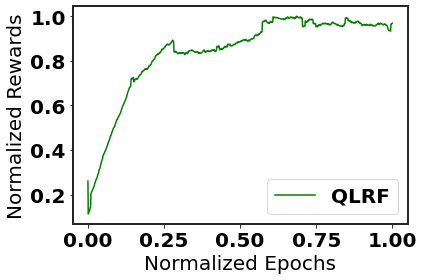

In [9]:
# ---------------------->>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> Defining and implementing RL control <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<----------------------------

# Model-free Reinforcement Learning

# Define parameters required for Q-learning
num_nodes=np.power(2,ns)
initial_state=np.random.choice(range(num_nodes-1))
goal=507                                            # desired attractor: decimal-507
undesired_goals=[4,68]                              # undesired attractors: decimal - 15406, 7216, 257, 14894, 6702
gamma=0.8                                           # discount factor: \gamma \in [0,1)
lr=0.8                                              # learning rate: \alpha \in (0,1]
EPSILON=0.1                                         # initialising \epsilon in \eplsion-greedy policy

# Environment variables
PTM=np.stack((edge_weights_U1,edge_weights_U2,edge_weights_U3,edge_weights_U4))   # Defining probability transitions matrix for function aprroximator learning

Q_algo=[]     # Initialize a dummy Q as a placeholder in greedy algo for QLRF
def greedy_policy(state,model_buff):
  data_buff=np.array([state_key[state]])
  data_regr=np.squeeze(model_buff.predict(data_buff))
  action_prob = np.ones(np.power(2,nc))*EPSILON/np.power(2,nc)         # define action probabilities as \epsilon/|A(s)|
  # choose best action to be a*=\underset{a\in A(s)}{\arg \max} Q
  best_action=np.squeeze(np.where(data_regr==np.max(data_regr)))
  if best_action.size>1:
    best_action = np.random.choice(best_action,size=1)
  action_prob[best_action]+=(1-EPSILON)                                # for a* set action probability = \epsilon/|A(s)| + (1-\epsilon)
  
  return action_prob

# Calc next_state on the basis of current state, and a greedy action for function approximator learning.
def calc_reward(current_state,next_state,action):
  reward_buff=[]
  if next_state == goal:
    reward_buff=100*float(PTM[action][current_state,next_state])
  elif next_state in undesired_goals:
    reward_buff=-1
  else:
    reward_buff = PTM[action][current_state,next_state]

  return float(reward_buff)

# Calc next_state on the basis of current state, and a greedy action for function approximator learning.
def calc_next_state(current_state,action):
  next_state_buff=[]
  reward_buff=[]
  for key1, key2 in PTM[action]:   # iter on both keys and values
    if key1==current_state:
      next_state_buff.append(key2)
      reward_buff.append(PTM[action][key1,key2])
  next_state = int(np.random.choice(next_state_buff,size=1))
  reward = calc_reward(current_state,next_state,action)

  return next_state, reward


# Define environment as: [current_state, next_state, action, reward] = env(current_state, Q_algo), where Q_algo is either QLRF.
def env(current_state,target_model):
  action_probabilities = greedy_policy(current_state,target_model)                            # calculate action probabilities using greedy policy
  action = np.random.choice(np.arange(len(action_probabilities)), p = action_probabilities)   # calculate action
  if action.size > 1:                                     # if there are multiple actions choose any one randomly and for the chosen random action, choose single next_state if multiple transitions are possible
    action = int(np.random.choice(action,size=1))
    next_state, reward = calc_next_state(current_state, action)
  else:
    next_state, reward = calc_next_state(current_state, action)

  return np.array([current_state,next_state,action,reward])

# set a seed for rehearsing the results
seed = 5732
np.random.seed(seed)

# initialise QLRF regressor with related parameters as per the number of samples to be inspected
max_depth = 4
regressor = MultiOutputRegressor(RandomForestRegressor(n_estimators=4,
                                                            max_depth=max_depth,
                                                            random_state=14, warm_start=True))
# Initialise Standard scaler for data to be learnt
sc = StandardScaler()

Q=np.zeros([np.power(2,ns),np.power(2,nc)]) # Initialize Q table to zeros with dimensions defined by states-action pairs
# QLRF algorithm
def QLRF(RANDOM_TRANSITIONS_DATA_buff,regressor):
  
  Q_pred_qrf = np.zeros(Q.shape)                                        # Initialize Q to zeros
    
  # generate D=(xn,yn) from state-action-value pairs from replay buffer
  data_buff = np.squeeze(RANDOM_TRANSITIONS_DATA_buff)
  X = np.array([list(item) for item in np.array(data_buff[:,2])])
  y = np.array([item for item in data_buff[:,3]])

  # Standardized the data for good predictions
  X = sc.fit_transform(X)
  Y = sc.fit_transform(y)

  # Fit the QLRF forest using the data extracted from Experience Replay buffer
  regressor = MultiOutputRegressor(RandomForestRegressor(n_estimators=2, random_state=14, warm_start=True))
  regressor.fit(X, Y)

  # generate predictions using fitted random forest model and use inverse transform to generate unscaled original values
  y_pred = regressor.predict(X)
  y_pred=sc.inverse_transform(y_pred)

  # remove rewards lower than or higher than a certain threshold in order to avoid bad predictions
  for k in range(y_pred.shape[0]):
    if (y_pred[k,:].all()>REWARD_LB) and (y_pred[k,:].all()<=REWARD_UB):
      Q_pred_qrf[int(data_buff[k,0]),:] = y_pred[k,:]
  
  return Q_pred_qrf,regressor

# ------------------------>>>>>>>>>>>>>>>>> Training Module <<<<<<<<<<<<<<<<----------------------------
start_time = time.time()                                            # start the timer to time overall code execution for all the three algorithms to train

# Initialize overall normalized scores
scores_QLRF = []
# Initialize predict (Q) and target (\hat{Q}) for QRLF
Q_target_QLRF = np.zeros([np.power(2,ns),np.power(2,nc)])
Q_predict_QLRF = np.zeros([np.power(2,ns),np.power(2,nc)])
# Define parameters for exploration-exploitation type learning starting from complete exploration to near exploitation of target Q values.
EPSILON = 1.0
EPSILON_DECAY_RATE = 0.95
EPSILON_MIN = 0.05
EPSILON_DECAY_ITER = 50
# set maximum replay buffer capacity or RB_{cap}
REPLAY_BUFFER_MAX = 4
# set number of parameters to be stored in replay buffer; i.e., current_state, next_state, action, reward
no_of_params_RB = 4
# initialize replay buffers QLRF
REPLAY_BUFFER_QLRF = np.zeros([REPLAY_BUFFER_MAX,no_of_params_RB])
# set maximum iterations to train and batch size to be sampled
BATCH = 4
MAX_ITER = np.power(2,ns) + int(np.power(2,ns)/REPLAY_BUFFER_MAX) + (REPLAY_BUFFER_MAX-BATCH)*REPLAY_BUFFER_MAX + 3000 # Optimal iterations as number of states + (number of states/RB_{cap}) + extra steps, if required.
# initialize randomly sampled dataset for both the algorithms
RANDOM_TRANSITIONS_DQN = np.zeros([BATCH,no_of_params_RB])
# define upper and lower bounds on rewards achieved, a very high negative and positive reward is chosen assuming there is no bad data predicted.
REWARD_LB = -1000
REWARD_UB = 1000
# initialize random transitions dataset D_i \in random_transitions dataset D according to defined batch size.
RANDOM_TRANSITIONS_DATA2 = []
# initialize target for QLRF
TARGET2 = np.zeros([BATCH,np.power(2,nc)])
# initialize losses for QLRF
LOSS2 = np.zeros([BATCH,1])
# initialize counts and state_key for corresponding states and action boolean values
cnt = 0
idx_cnt = 0
state_key = list(itertools.product([0, 1], repeat=ns))
state_key_c = list(itertools.product([0, 1], repeat=nc))
# initialise data buffer predicted by the models for calculating Q_{max} in each step
Q_target_data_buff=0
Q_target_data_buff_X=0

# initialise QLRF regressor with random data
X_dummy=state_key[:10]
Y_dummy=np.random.rand(10,np.power(2,nc))
regressor.fit(X_dummy,Y_dummy)

for j in range(MAX_ITER):
  # choose random current_state in every iterations and generated data for training QLRF using Q values
  current_state = (np.power(2,ns)-1)-j%np.power(2,ns)           # Please make a note that here we use reversed values, as undesired attractors [4,68] at start generate huge spikes.

  # generate replay buffers for DQN and QLRF learning
  REPLAY_BUFFER_QLRF[idx_cnt, :] = env(current_state, regressor)
  idx_cnt+=1
  cnt+=1

  # reduce epsilon every training step so as to maintain exploration-exploitation
  if EPSILON >= EPSILON_MIN and cnt%EPSILON_DECAY_ITER==0:
    EPSILON*=EPSILON_DECAY_RATE
  
  # iteratre until replay buffer is completely filled and once the data is available train QLRF models
  if cnt%REPLAY_BUFFER_MAX==0 and cnt!=0:
    
    idx = np.random.randint(REPLAY_BUFFER_MAX, size=BATCH)          # choose random indexes of size batch from replay buffer 
    # generate random transitions sample dataset for training 
    RANDOM_TRANSITIONS_QLRF = REPLAY_BUFFER_QLRF[idx, :]

    # for all the values in random transitions dataset train DQN and QLRF models
    for l in range(BATCH):
      # for QLRF we choose exploring all the states at any given state value allowing to fasten the training process
      for k in range(np.power(2,nc)):
        # with current state-action pairs generate target values for learning
        next_state, reward = calc_next_state(int(RANDOM_TRANSITIONS_QLRF[l,0]),k)

        # if next state == terminal: --> target = maximum reward else: --> target = r+\gamma \underset{a \in A(s)}{\arg \max} Q(s,a)
        if next_state == goal:
          TARGET2[l,k] = calc_reward(int(RANDOM_TRANSITIONS_QLRF[l,0]),next_state,k)
        else:
          # calculate Q_{max} using the best action being in current state
          Q_target_data_buff_X=np.array([state_key[int(next_state)]])
          Q_target_data_buff=np.squeeze(regressor.predict(Q_target_data_buff_X))
          # max_index=np.squeeze(np.argmax(Q_target_data_buff))
          max_index=np.squeeze(np.where(Q_target_data_buff==np.max(Q_target_data_buff)))

          if max_index.size > 1:
              max_index = int(np.random.choice(max_index, size = 1))
          else:
              max_index = int(max_index)
          max_value = Q_target_data_buff[max_index]

          # target = r+\gamma \underset{a \in A(s)}{\arg \max} Q(s,a)
          TARGET2[l,k] = reward + gamma*(max_value)

      # LOSS = \sum (Q_predicted-Target)^2. Although, we avoid calculating explicit loss here and allow regressor algorithms to employ MSE loss, which is the same. 
      # random transitions data comprises of current_state, action , binary key for transitions, target. Altough, all others are dummy except binary key and target are the ones used for training.   
      RANDOM_TRANSITIONS_DATA2.append(np.array([RANDOM_TRANSITIONS_QLRF[l,0],RANDOM_TRANSITIONS_QLRF[l,2],state_key[int(RANDOM_TRANSITIONS_QLRF[l,0])],TARGET2[l,:]]))        

    # predict Q values using QLRF algorithm and store values for computing MDP score.
    Q_predict_QLRF,regressor=QLRF(RANDOM_TRANSITIONS_DATA2,regressor)
    for l in range(Q_predict_QLRF.shape[0]):
      for k in range(Q_predict_QLRF.shape[1]):
        if Q_predict_QLRF[l,k]!=0:                  # update target Q values using newer values in predict Q values and avoid bad predictions
          Q_target_QLRF[l,k] = Q_predict_QLRF[l,k] 

    # flush all the data from replay buffer and randomly sampled dataset
    idx_cnt = 0
    REPLAY_BUFFER_QLRF = np.zeros([REPLAY_BUFFER_MAX,no_of_params_RB])
    RANDOM_TRANSITIONS_DATA2 = []

    # calculate normalized rewards or scores for individual algorithms
    if (np.max(Q_target_QLRF) > 0):
      scores_pred = ((np.sum(Q_target_QLRF/np.max(Q_target_QLRF)*100)))
    else:
      scores_pred=0
    scores_QLRF.append(scores_pred)

    # print overall progress of the training process.
    print(np.round((j/MAX_ITER)*100,2),'% complete.')
  

# print total time taken for the overall training
print('Total time taken for training of all the three algorithms')
print("--- %s seconds ---" % (time.time() - start_time))

# generate normalized score from successive steps for peer-to-peer comparisons
scores_QLRF = scores_QLRF/np.max(scores_QLRF)

# # generate a linear x-space for plotting
t = np.linspace(0, 1, len(scores_QLRF))

# # visualize the data
plt.plot(t, scores_QLRF, label='QLRF', color = 'green')
plt.xlabel('Normalized Epochs')
plt.ylabel('Normalized Rewards')
plt.legend()
plt.show()

# ------------------------>>>>>>>>>>>>>>>>> Training Module <<<<<<<<<<<<<<<<----------------------------

# ---------------------->>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> Defining and implementing RL control <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<----------------------------

Once the training is done, one can analyse the trained Q values using all the three algorithms and verify its accuracy/optimality in terms of available state transition graphs.

In [10]:
# Generate heat-maps for analysis
crms=np.transpose(Q_target_QLRF)

np.random.seed(24)
df_dummy = pd.DataFrame({'Q': np.linspace(0, 3, 4)})
df_dummy = pd.concat([df_dummy, pd.DataFrame(crms)],axis=1)

import seaborn as sns

cm = sns.light_palette("blue", as_cmap=True)

s5 = df_dummy.style.background_gradient(cmap=cm)
s5

# **Step 3: Lyapunoc analysis and Self-Triggered Control**

In this section, we provide Lyapunov analysis of Q table calculated using above code and implement self-triggered control fo either of the one algorithms (particularly QLRF).

In [11]:
# please make a note that all conventions used for this analysis are completely reverse of the ones used in the training module.
# For instance 111-7 for training and 111-0 in the analysis followed under.
import numpy as np
import cvxpy as cp

# Generate tabular TPM for LMI analysis
probs_U1=np.zeros([np.power(2,ns),np.power(2,ns)])
probs_U2=np.zeros([np.power(2,ns),np.power(2,ns)])
probs_U3=np.zeros([np.power(2,ns),np.power(2,ns)])
probs_U4=np.zeros([np.power(2,ns),np.power(2,ns)])
for i in range(len(points_list_U1)):
  probs_U1[int(points_list_U1[i][0])][int(points_list_U1[i][1])]=edge_weights_U1[points_list_U1[i]]
  probs_U2[int(points_list_U2[i][0])][int(points_list_U2[i][1])]=edge_weights_U2[points_list_U2[i]]
  probs_U3[int(points_list_U3[i][0])][int(points_list_U3[i][1])]=edge_weights_U3[points_list_U3[i]]
  probs_U4[int(points_list_U4[i][0])][int(points_list_U4[i][1])]=edge_weights_U4[points_list_U4[i]]

PTM=np.stack((probs_U1,probs_U2,probs_U3,probs_U4))

goal=511-507                              # desired attractor: 000000100-507
del_2n=np.identity(np.power(2,ns))        # del_{2n}=[del^{i}_{2n}]
del_t_2n=np.delete(del_2n,goal,axis=1)    # del^{t}_{2n}=[del_{2n}\del^{goal}_{2n}]
del_2n_2n=del_2n[:,goal]                  # del^{goal}_{2n}

# generating inverted probability transition matrices
dim_p=PTM[0].shape[0]
F=np.zeros([dim_p,dim_p])
F1=np.zeros([dim_p,dim_p])
F2=np.zeros([dim_p,dim_p])
F3=np.zeros([dim_p,dim_p])
F4=np.zeros([dim_p,dim_p])
for i in range(dim_p):
  for j in range(dim_p):
    F4[i,j]=PTM[0][dim_p-1-j,dim_p-1-i]
    F3[i,j]=PTM[1][dim_p-1-j,dim_p-1-i]
    F2[i,j]=PTM[2][dim_p-1-j,dim_p-1-i]
    F1[i,j]=PTM[3][dim_p-1-j,dim_p-1-i]

# \phi_{2^{2n}}=diag[del^{i}_{2n}]
dim_phi=np.power(2,2*ns)
phi_test=np.zeros([dim_phi,dim_p])
for i in range(dim_p):
  phi_test[i*dim_p:(i+1)*dim_p,i]=del_2n[:,i]

# generating reversed QLRF table values
q_dummy=Q_target_QLRF.T
q_buff=np.zeros([np.power(2,nc),np.power(2,ns)])
for i in range(q_dummy.shape[0]):
  for j in range(q_dummy.shape[1]):
    q_buff[i,j]=q_dummy[q_dummy.shape[0]-1-i,q_dummy.shape[1]-1-j]

uqlrf=np.zeros([np.power(2,nc),np.power(2,ns)])
for i in range(np.power(2,ns)):
  # idx=np.argmax(q_buff[:,i])
  idx=np.squeeze(np.where(q_buff[:,i]==np.max(q_buff[:,i])))
  if idx.size>1:
    idx=int(np.random.choice(idx,size=1))
  uqlrf[idx,i]=1

# concatenated TPM and action matrices
p=np.concatenate([F1,F2,F3,F4],axis=1)
u=uqlrf

# \tilde_{P}=Pu\phi
piP=np.zeros([dim_p,dim_phi])
piP=(np.kron(p,np.identity(1))).dot(np.kron(u,np.identity(dim_p)))
piP=piP.dot(phi_test)

# We solve the LMI defined in manuscript considering the closed loop \tilde{P} and solving for a LP problem \lambda.T*s given constraints.
# kindly refer to the detailed description of the constraints in the manuscript.
lambda_i = cp.Variable([np.power(2,ns),1])
gam = cp.Variable()
obj = cp.Minimize(gam)

LMI1 = cp.bmat([
                 [lambda_i.T*del_2n_2n]
])
cons1=LMI1 <= 0
cons6=LMI1 >= 0

LMI2 = cp.bmat([
                 [lambda_i.T*piP.dot(del_2n_2n)]
])
cons2=LMI2 <= 0
cons7=LMI2 >= 0

LMI3 = cp.bmat([
                 [lambda_i.T*del_t_2n]
])

cons3 = LMI3 >= gam

LMI4 = cp.bmat([
                 [lambda_i.T*piP.dot(del_t_2n)-lambda_i.T*del_t_2n]
])

cons4 = LMI4 <= -gam
cons5 = gam >= 0.0
consf=[cons1,cons2,cons3,cons4,cons5,cons6,cons7]
prob = cp.Problem(obj,consf)

prob.solve()
print("value of lambda is \n",lambda_i.value)


value of lambda is 
 [[1.33603251e-01]
 [1.79842542e-01]
 [1.59558898e-01]
 [1.79842542e-01]
 [2.12936309e-17]
 [1.24604235e-01]
 [1.17460522e-01]
 [1.46922741e-01]
 [1.58533984e-01]
 [1.57993337e-01]
 [1.58533984e-01]
 [1.57993337e-01]
 [1.18878230e-01]
 [1.86789495e-01]
 [1.18878230e-01]
 [1.86789495e-01]
 [1.39780127e-01]
 [1.51375916e-01]
 [1.51217825e-01]
 [1.51375916e-01]
 [1.42908145e-01]
 [1.60682803e-01]
 [1.80885773e-01]
 [1.72231912e-01]
 [1.72199108e-01]
 [1.51375916e-01]
 [1.72199108e-01]
 [1.88380346e-01]
 [1.27261580e-01]
 [1.72231912e-01]
 [1.27261580e-01]
 [1.72231912e-01]
 [1.21992316e-01]
 [1.70520755e-01]
 [2.00485733e-01]
 [1.98509112e-01]
 [2.76130126e-03]
 [1.46922741e-01]
 [2.12322124e-01]
 [2.14862951e-01]
 [1.58533984e-01]
 [1.90288327e-01]
 [1.91560243e-01]
 [2.08516168e-01]
 [1.18878230e-01]
 [1.86789495e-01]
 [2.02636771e-01]
 [2.19039346e-01]
 [1.10339146e-01]
 [1.27889787e-01]
 [2.12795826e-01]
 [7.35026659e-02]
 [5.48107662e-02]
 [5.47961816e-02]
 [2.014

Next, we use the \lambda calculated from LMI above to design self-triggered control schedule

In [12]:
rev_s=np.power(2,ns)-1
rev_a=np.power(2,nc)-1
goal=rev_s-507
dummy_states=4

# matrices used to stored steps-actions log at every step
steps_log=[]
act_log=[]
steps_log_buff=[]
act_log_buff=[]

# \lambda calculated from LMIs
lm=lambda_i.value

# Initialising lambda values for current state and next state
lm_cs=0
lm_ns=0
# TPM matrices for the current problem
PTM=np.stack((probs_U1,probs_U2,probs_U3,probs_U4))

for k in range(np.power(2,ns)):
  for j in range(np.power(2,nc)):
    # define all states-action pairs to understand respective transitions and schedules
    current_state=k
    action=rev_a-j
    # flush the logs after every succesful computation
    steps_log_buff=[]
    act_log_buff=[]
    # create two dummy step-action pair for visualisation
    steps_log_buff.append(current_state)
    act_log_buff.append(action)
    steps_log_buff.append(current_state)
    act_log_buff.append(action)

    # Run until current state reaches desired attractor
    while (rev_s-int(current_state))!=goal:
      # Allow the control to traverse along negative gradient of the constituent \lambda values.
      # calculate possible transitions from TPM and check for minimum \lambda and transit accordingly as per Algorithm 2.
      nz_trans=PTM[int(action)][int(current_state),:].nonzero()[0]
      idxc=np.squeeze(np.where(lm[rev_s-nz_trans]==np.min(lm[rev_s-nz_trans])))
      if idxc.size>1:
        idxc=int(np.random.choice(idxc,size=1))
      next_state = nz_trans[idxc]

      # Compare current state \lambda with next state in terms of Lyapunov condition violations or self-loops or reaching the desired attractor
      if lm[rev_s-int(current_state)]<lm[rev_s-int(next_state)] or (current_state==next_state and (rev_s-current_state)!=goal) :
        action_buff=rev_a-np.squeeze(np.where(uqlrf[:,int(rev_s-current_state)]==np.max(uqlrf[:,int(rev_s-current_state)])))           # re-compute actions as per QLRF control
        if action_buff.size > 1:
              action = int(np.random.choice(action_buff, size = 1))
        else:
              action = int(action_buff)
      else:
        # maintain a log of steps taken and control actions employed
        steps_log_buff.append(next_state)
        current_state=next_state
        act_log_buff.append(action)
    
    # Run for some dummy states even when the desired attractor is reached in order to assure infinite time stabilisation.
    for i in range(dummy_states):
      nz_trans=PTM[int(action)][int(current_state),:].nonzero()[0]
      idxc=np.squeeze(np.where(lm[rev_s-nz_trans]==np.min(lm[rev_s-nz_trans])))
      if idxc.size>1:
        idxc=int(np.random.choice(idxc,size=1))
      next_state = nz_trans[idxc]

      if lm[rev_s-int(current_state)]<lm[rev_s-int(next_state)] or (current_state==next_state and (rev_s-int(current_state))!=goal) :
        action_buff=rev_a-np.squeeze(np.where(uqlrf[:,int(rev_s-current_state)]==np.max(uqlrf[:,int(rev_s-current_state)])))           # re-compute actions as per QLRF control
        if action_buff.size > 1:
              action = int(np.random.choice(action_buff, size = 1))
        else:
              action = int(action_buff)
      else:
        steps_log_buff.append(next_state)
        current_state=next_state
        act_log_buff.append(action)

    # Store the step-action log at the end of every evaluation  
    steps_log.append(steps_log_buff)
    act_log.append(act_log_buff)

  # Print percentage of completion at every step
  print(np.round(k/512*100,2),'%complete')

0.0 %complete
0.2 %complete
0.39 %complete
0.59 %complete
0.78 %complete
0.98 %complete
1.17 %complete
1.37 %complete
1.56 %complete
1.76 %complete
1.95 %complete
2.15 %complete
2.34 %complete
2.54 %complete
2.73 %complete
2.93 %complete
3.12 %complete
3.32 %complete
3.52 %complete
3.71 %complete
3.91 %complete
4.1 %complete
4.3 %complete
4.49 %complete
4.69 %complete
4.88 %complete
5.08 %complete
5.27 %complete
5.47 %complete
5.66 %complete
5.86 %complete
6.05 %complete
6.25 %complete
6.45 %complete
6.64 %complete
6.84 %complete
7.03 %complete
7.23 %complete
7.42 %complete
7.62 %complete
7.81 %complete
8.01 %complete
8.2 %complete
8.4 %complete
8.59 %complete
8.79 %complete
8.98 %complete
9.18 %complete
9.38 %complete
9.57 %complete
9.77 %complete
9.96 %complete
10.16 %complete
10.35 %complete
10.55 %complete
10.74 %complete
10.94 %complete
11.13 %complete
11.33 %complete
11.52 %complete
11.72 %complete
11.91 %complete
12.11 %complete
12.3 %complete
12.5 %complete
12.7 %complete
12.89

Next, using the steps computed from previous analysis, we plot the steps taken and triggering times for better understanding.

/usr/local/lib/python3.6/dist-packages/matplotlib/lines.py:191: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return Path(verts[markevery], _slice_or_none(codes, markevery))


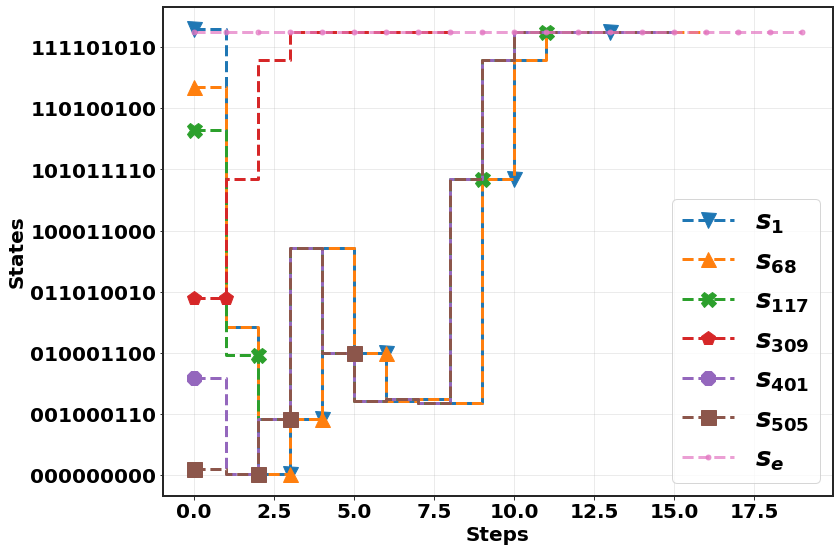

In [13]:
# Visualization of STC scheme as per steps computed from previous analysis

from matplotlib.ticker import StrMethodFormatter
fig, ax = plt.subplots(1,1,figsize=(12,9))
plt.rcParams.update({'font.family': 'Times New Roman', 'font.size': 20, 'font.weight': 'bold'})
plt.rcParams["axes.edgecolor"] = "0.15"
plt.rcParams["axes.linewidth"]  = 2

# number of steps to be shown
nsteps=20

# create a dummy desired line showing goal values
desired_line=[]
goal=507            # Kindly make a note here 111111011-507, since none of the system parameters comprising reversed values are used for this part.
for i in range(nsteps):
  desired_line.append(goal)

# Kindly note, that here we make use of differen markers so as to better visualise overlapping triggering times, compared to same marker in the manuscript. Although, the reader has priviliges to download and make changes accordingly.
mrkrs=list([".","o","v","^","<",">","8","s","p","P","*","h","H","X","D","d"])

# Predefine random points to be visualised and reverse it as per standard conventions used in this part of work
c=np.array([7,111,203,395,444,511])[::-1]
labels=[]

# plot till all the points required are shown
for i in range(len(c)):
  # plot all the 4th values of steps showing steps computed for initial action u=11.
  t=range(len(steps_log[4*c[i]][:nsteps]))

  # This part here checks for bit changes in successive values of actions so as to understand triggering taken by the STC scheme.
  dummy=np.array(act_log[4*c[i]])
  dummy_ind=np.where(dummy[:-1] != dummy[1:])[0]

  ax.yaxis.set_ticks(np.arange(0, np.power(2,ns), 70))
  ax.step(t,np.array(steps_log[4*c[i]][:nsteps]),linewidth=3, linestyle='dashed', marker=np.random.choice(mrkrs), markersize=15, markevery = [np.concatenate([[0],dummy_ind],axis=0)], label=r'$s_{i}$'.format(i={int(512-c[i])}))
  ax.yaxis.set_major_formatter(StrMethodFormatter("{x:09b}"))
  ax.set_ylabel('States', fontsize='20', fontweight='bold')
  ax.set_xlabel('Steps', fontsize='20', fontweight='bold')

# plot desired line on top for better understanding.
t=range(nsteps)
ax.step(t,desired_line, linewidth=3, linestyle='dashed', alpha=0.7, marker='o', markersize=5, label=r'$s_{e}$')
ax.legend(prop={"size":26})
ax.grid(alpha=0.3)

# save the figure for future references
fig.savefig('9node_steps2.png',dpi=300, bbox_inches = "tight")

In [14]:
last=[]
for i in range(len(steps_log)):
  last.append(steps_log[i][-1])

np.unique(last)

array([507])